# ECE421 Programming Assignment 3 - Unsupervised Learning
#Marcos David Madrigal Albores 1004731347


In [44]:
%%shell
jupyter nbconvert --to html /content/A3_ECE421_1004731347.ipynb

[NbConvertApp] Converting notebook /content/A3_ECE421_1004731347.ipynb to html
[NbConvertApp] Writing 5329691 bytes to /content/A3_ECE421_1004731347.html


#Colab Link and Git Repository Cloning

Colab Link: https://colab.research.google.com/drive/19oD11xgtS-v10wRNL_CQkr3ljGuIwm4h?usp=sharing

In [1]:
!git clone https://github.com/Marneus981/ECE421.git

Cloning into 'ECE421'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 1), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


#1.-K-means

In [2]:
data_path_2 = '/content/ECE421/data2D.npy'
data_path_100 = '/content/ECE421/data100D.npy'

##Helper

In [17]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import matplotlib.pyplot as plt
#import helper as hlp



def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)


##1.1.- Learning K-means

###1.1.1.-

In [31]:
data_int = 2

In [32]:
if data_int == 2:
  data = np.load(data_path_2)
  
elif data_int == 100:
  data = np.load(data_path_100)

[num_pts, dim] = np.shape(data)
# For Validation set
#if is_valid:
valid_batch = int(num_pts / 3.0)
np.random.seed(45689)
rnd_idx = np.arange(num_pts)
np.random.shuffle(rnd_idx)
val_data = data[rnd_idx[:valid_batch]]
data = data[rnd_idx[valid_batch:]]

In [33]:
# Distance function for K-means
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    # TODO
    new_MU = tf.expand_dims(X,0)
    new_X = tf.expand_dims(MU,1)
    distance = tf.subtract(new_X,new_MU)
    distance = tf.square(distance)
    distance = tf.reduce_sum(distance,2)
    distance = tf.transpose(distance) ####Might need to compress implementation
    return distance

def cluster(X, MU):
    distances = distanceFunc(X,MU)
    min_distance =  tf.argmin(distances, 1)
    return min_distance

def k_means(K,learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5, need_valid = True,need_update = True,need_plot = True): 
    #Initialize variables
    tr_loss_hist = [] #np.empty(shape=[0],dtype=float)
    val_loss_hist = []
    N = num_pts
    D = dim
    iterations = 1000
    X = tf.placeholder("float", shape=[None,D])
    MU_init = tf.truncated_normal([K,D],stddev=0.05)
    MU = tf.Variable(MU_init)
    ##Compute distances
    distance = distanceFunc(X,MU)
    loss = tf.reduce_sum(tf.reduce_min(distance,axis = 1))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1, beta2 = beta2, epsilon = epsilon).minimize(loss)
    #Session initialization
    init_g = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init_g)
    
    #Training start
    for i in range(iterations):

      center_value,loss_value,_ = sess.run([MU,loss,optimizer], feed_dict={X:data})
      tr_loss_hist.append(loss_value) #= np.append(tr_loss_hist,loss_value)
      if need_valid:
            val_center_value,val_loss_value,_ = sess.run([MU,loss,optimizer], feed_dict={X:val_data})
            val_loss_hist.append(val_loss_value) # = np.append(val_loss_history,val_lossVal)
      if need_update:
        if i%100 ==0:
          print("Iteration:", i, "loss", loss_value)
    #Final clustering and plotting
    clustering = sess.run(cluster(X, MU),feed_dict={X: data, MU:center_value})
    val_clustering = sess.run(cluster(X, MU),feed_dict={X: val_data, MU:val_center_value})
    percentages = np.zeros(K)############################################
    val_percentages = np.zeros(K)

    print("Final Training Loss",  tr_loss_hist[-1])
    if need_valid:
      print("Final Validation Loss",  val_loss_hist[-1])
    for i in range(K):###################################################
          percentages[i] = np.sum(np.equal(i, clustering))*100.0/len(clustering)
          print("Training Class:", i, "Percentage:", percentages[i], "%")
    if need_valid:
      for i in range(K):###################################################
          val_percentages[i] = np.sum(np.equal(i, val_clustering))*100.0/len(val_clustering)
          print("Validation Class:", i, "Percentage:", val_percentages[i], "%")

    if need_plot:
      plt.figure(1)
      plt.plot(range(len(tr_loss_hist)),tr_loss_hist,c="c", label="train_loss")
      plt.legend(loc = "best")
      plt.title('K-Means History Training')
      plt.xlabel('# of Iterations')
      plt.ylabel('Loss')
      plt.show()

      k = len(center_value)
      plt.scatter(data[:, 0], data[:, 1], c=clustering, 
                cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
      plt.scatter(center_value[:, 0], center_value[:, 1], marker='*', c="black", 
                cmap=plt.get_cmap('Set1'), s=50, linewidths=1)
      plt.title('K-Means Clustering Training')
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.grid()
      plt.show()

      if need_valid:
        plt.figure(2)
        plt.plot(range(len(val_loss_hist)),val_loss_hist,c="b", label="validation_loss")
        plt.legend(loc = "best")
        plt.title('K-Means History Validation')
        plt.xlabel('# of Iterations')
        plt.ylabel('Loss')
        plt.show()

        k = len(val_center_value)
        plt.scatter(val_data[:, 0], val_data[:, 1], c=val_clustering, 
                  cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
        plt.scatter(val_center_value[:, 0], val_center_value[:, 1], marker='*', c="black", 
                  cmap=plt.get_cmap('Set1'), s=50, linewidths=1)
        plt.title('K-Means Clustering Validation')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()

    return val_loss_hist





Iteration: 0 loss 39162.24
Iteration: 100 loss 3494.5852
Iteration: 200 loss 3494.585
Iteration: 300 loss 3494.5454
Iteration: 400 loss 3494.8582
Iteration: 500 loss 3494.858
Iteration: 600 loss 3494.5298
Iteration: 700 loss 3495.5295
Iteration: 800 loss 3495.4934
Iteration: 900 loss 3495.0144
Final Training Loss 3494.873
Final Validation Loss 1617.3479
Training Class: 0 Percentage: 37.34813259337033 %
Training Class: 1 Percentage: 24.208789560521975 %
Training Class: 2 Percentage: 38.44307784610769 %
Validation Class: 0 Percentage: 39.753975397539755 %
Validation Class: 1 Percentage: 22.982298229822984 %
Validation Class: 2 Percentage: 37.263726372637265 %


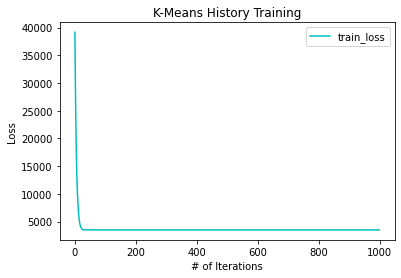

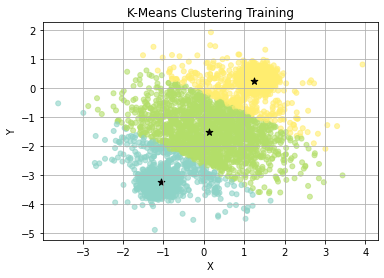

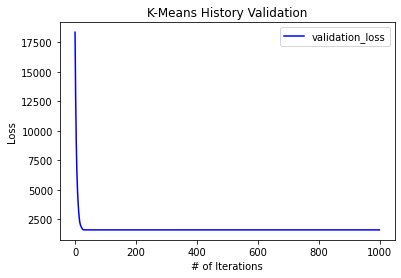

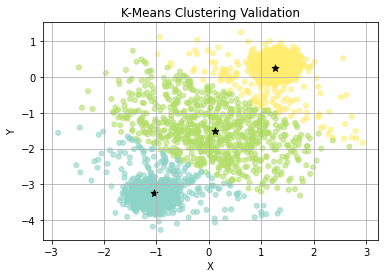

In [34]:
val_loss_3k = k_means(3)

###1.1.2.-

Final Training Loss 25593.57
Final Validation Loss 12862.396
Training Class: 0 Percentage: 100.0 %
Validation Class: 0 Percentage: 100.0 %


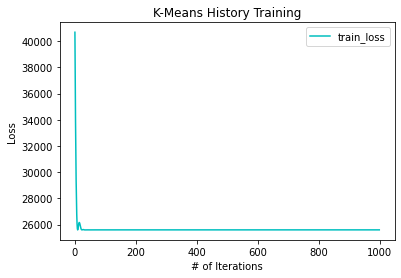

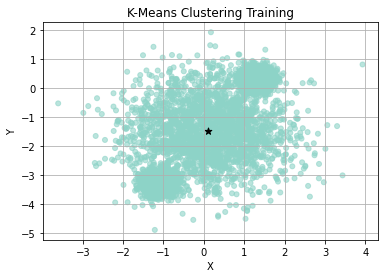

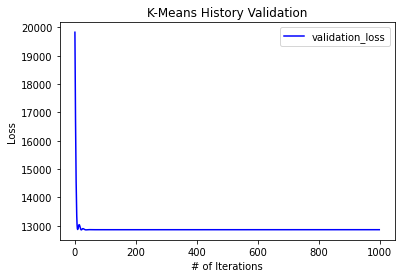

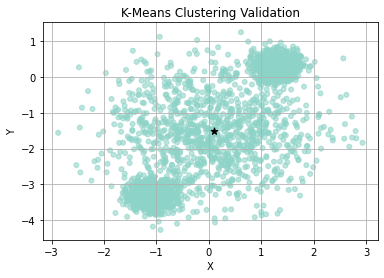

Final Training Loss 6244.0586
Final Validation Loss 2960.054
Training Class: 0 Percentage: 49.812509374531274 %
Training Class: 1 Percentage: 50.187490625468726 %
Validation Class: 0 Percentage: 51.78517851785178 %
Validation Class: 1 Percentage: 48.21482148214822 %


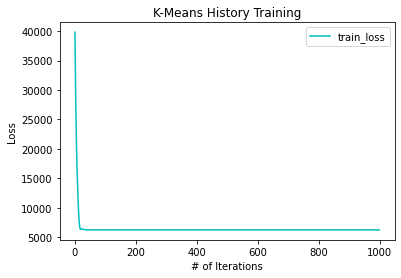

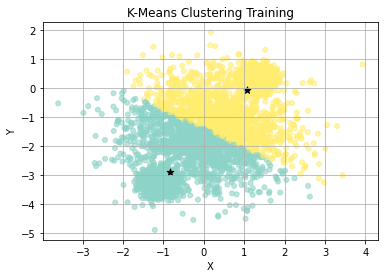

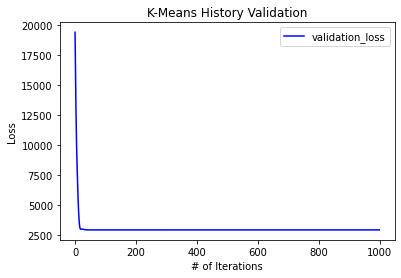

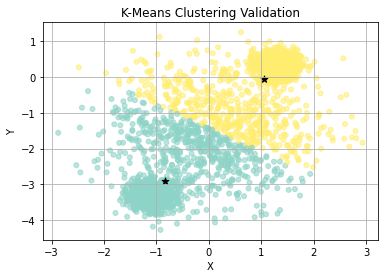

Final Training Loss 3494.8645
Final Validation Loss 1617.4219
Training Class: 0 Percentage: 37.34813259337033 %
Training Class: 1 Percentage: 24.223788810559473 %
Training Class: 2 Percentage: 38.42807859607019 %
Validation Class: 0 Percentage: 39.753975397539755 %
Validation Class: 1 Percentage: 22.982298229822984 %
Validation Class: 2 Percentage: 37.263726372637265 %


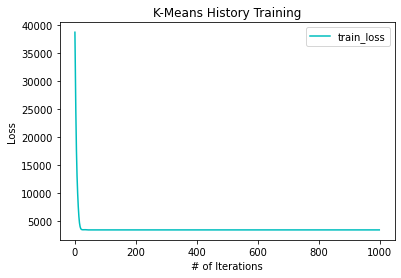

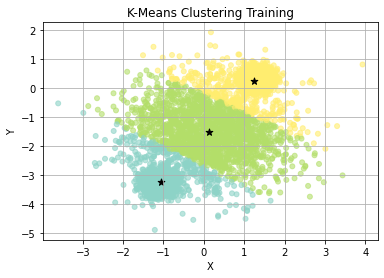

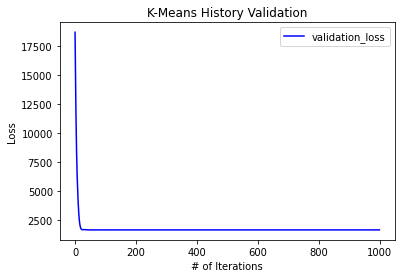

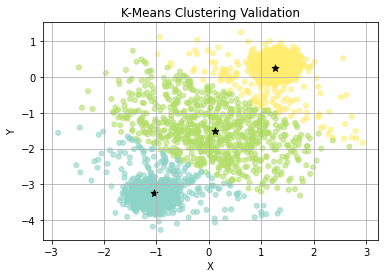

Final Training Loss 2320.815
Final Validation Loss 1053.7845
Training Class: 0 Percentage: 13.859307034648268 %
Training Class: 1 Percentage: 37.633118344082796 %
Training Class: 2 Percentage: 12.209389530523474 %
Training Class: 3 Percentage: 36.29818509074546 %
Validation Class: 0 Percentage: 12.691269126912692 %
Validation Class: 1 Percentage: 36.633663366336634 %
Validation Class: 2 Percentage: 11.851185118511852 %
Validation Class: 3 Percentage: 38.82388238823882 %


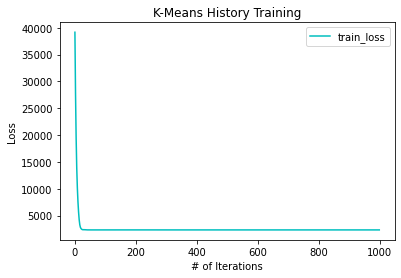

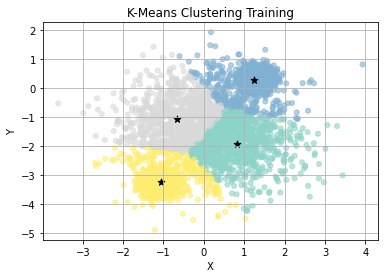

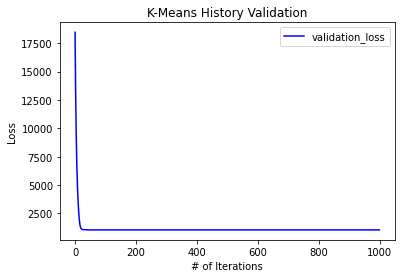

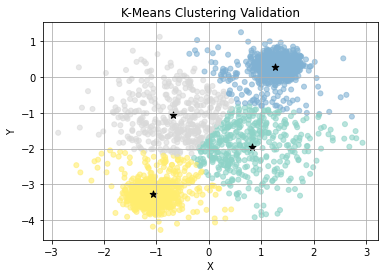

Final Training Loss 1971.057
Final Validation Loss 899.86835
Training Class: 0 Percentage: 11.309434528273586 %
Training Class: 1 Percentage: 37.378131093445326 %
Training Class: 2 Percentage: 35.90820458977051 %
Training Class: 3 Percentage: 7.874606269686516 %
Training Class: 4 Percentage: 7.529623518824059 %
Validation Class: 0 Percentage: 10.681068106810681 %
Validation Class: 1 Percentage: 36.393639363936394 %
Validation Class: 2 Percentage: 38.4038403840384 %
Validation Class: 3 Percentage: 7.050705070507051 %
Validation Class: 4 Percentage: 7.470747074707471 %


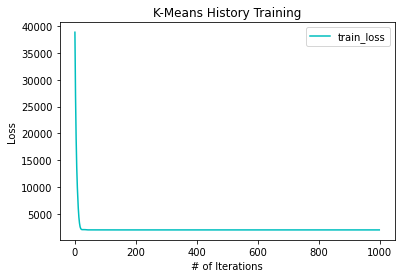

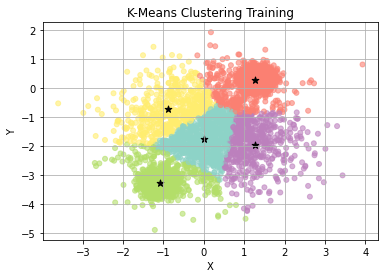

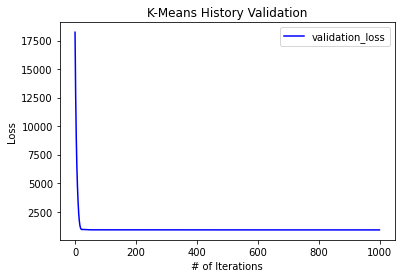

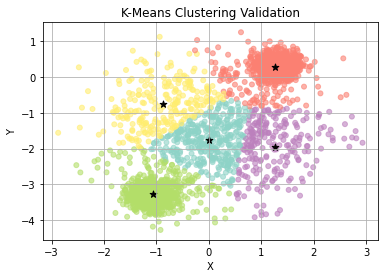

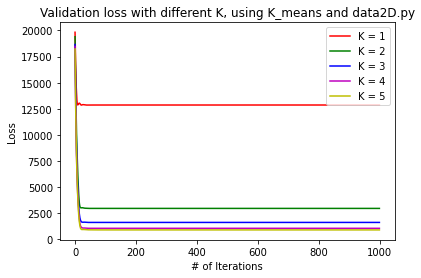

In [35]:
valid = []
valid.append(k_means(1, need_update=False))
valid.append(k_means(2, need_update=False))
valid.append(k_means(3, need_update=False))
valid.append(k_means(4, need_update=False))
valid.append(k_means(5, need_update=False))

plt.figure(1)
plt.plot(range(len(valid[0])),valid[0],c="r", label="K = 1")
# plt.plot(range(len(valid_losses)),valid_losses,c="r", label="valid_loss")
plt.plot(range(len(valid[1])),valid[1],c="g", label="K = 2")
plt.plot(range(len(valid[2])),valid[2],c="b", label="K = 3")
plt.plot(range(len(valid[3])),valid[3],c="m", label="K = 4")
plt.plot(range(len(valid[4])),valid[4],c="y", label="K = 5")
plt.legend(loc = "best")
plt.title('Validation loss with different K, using K_means and data2D.py')
plt.xlabel('# of Iterations')
plt.ylabel('Loss')
plt.show()

I believe the best number of clusters to use for this dataset is K = 5 because it better portrays the accumulations of data while keeping a good performance. This choice of K does not further break down the groups making the clustering seem reasonable and not overly complex. It also has the lowest loss out of all other choices for K.

#2.- Mixtures of Gaussians

##2.1.- The Gaussian Cluster Model

###2.1.1.-

In [36]:


# Distance function for GMM 
# def distanceFunc(X, MU):
#     # Inputs
#     # X: is an NxD matrix (N observations and D dimensions)
#     # MU: is an KxD matrix (K means and D dimensions)
#     # Outputs
#     # pair_dist: is the pairwise distance matrix (NxK)
#     # TODO
#Above not implemented as im using the distanceFunc from the kmeans algorithm
def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    # TODO
    #X_mu_squared = tf.multiply(distanceFunc(X,mu),distanceFunc(X,mu))
    X_mu = distanceFunc(X,mu)
    sigma = tf.squeeze(sigma)
    dim = tf.to_float(tf.rank(X))
    
    prod = -0.5*dim*tf.log(2*np.pi*sigma)
    exp = X_mu/(2*sigma)
    return prod - exp

    




###2.1.2.-

In [43]:
def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    # TODO
    log_prob = tf.add(tf.squeeze(log_pi),log_PDF)
    log_sum = reduce_logsumexp(log_prob + tf.squeeze(log_pi),keep_dims=True)
    return log_prob - log_sum

In this case it is important to use the log-sum-exp function instead of tf.reduce_sum because the log-sum-exp function not only computes the sum across dimensions but also returns the sum of the maximum of elements across dimensions plus the sum of the exponential difference between the input tensor and the maximum of elements across dimensions of the tensor in question.

##2.2.- Learning the MoG

###2.2.1.-

In [39]:
data_int = 2

In [40]:
if data_int == 2:
  data = np.load(data_path_2)
  
elif data_int == 100:
  data = np.load(data_path_100)

[num_pts, dim] = np.shape(data)
# For Validation set
#if is_valid:
valid_batch = int(num_pts / 3.0)
np.random.seed(45689)
rnd_idx = np.arange(num_pts)
np.random.shuffle(rnd_idx)
val_data = data[rnd_idx[:valid_batch]]
data = data[rnd_idx[valid_batch:]]

In [38]:
# def cluster_MoG(X, MU):
#     distances = distanceFunc(X,MU)
#     min_distance =  tf.argmin(distances, 1)
#     return min_distance

def k_means_MoG(K,stddev = 0.05,learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5, need_valid = True,need_update = True,need_plot = True): 
    #Set seed
    np.random.seed(981)
    #Initialize variables
    tr_loss_hist = [] #np.empty(shape=[0],dtype=float)
    val_loss_hist = []
    assg = []
    val_assg = []
    N = num_pts
    D = dim
    iterations = 1000

    X = tf.placeholder("float", shape=[None,D]) #,"X"
    MU_init = tf.random_normal([K,D],stddev=stddev)
    MU = tf.Variable(MU_init)
    sigma_init = tf.random_normal([K,1],stddev=stddev)
    sigma = tf.Variable(sigma_init)
    sigma = tf.exp(sigma)
    pi_init = tf.random_normal([K, 1], stddev = stddev)
    pi = tf.Variable(pi_init)
    #Compute logs
    log_PDF = log_GaussPDF(X, MU, sigma)
    log_pi = tf.squeeze(logsoftmax(pi)) 
    #Set loss, optimizer and prediction
    loss = - tf.reduce_sum(reduce_logsumexp(log_PDF + log_pi, 1, keep_dims=True))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1, beta2 = beta2, epsilon = epsilon).minimize(loss)
    #train = optimizer.minimize(loss)
    pred = tf.argmax(tf.nn.softmax(log_posterior(log_PDF, log_pi)), 1)
    #Session initialization
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    sess = tf.Session()
    sess.run(init_g)
    sess.run(init_l)

    
    #Training start
    for i in range(iterations):

      center_value,loss_value,_,assg = sess.run([MU,loss,optimizer,pred], feed_dict={X:data})
      tr_loss_hist.append(loss_value) #= np.append(tr_loss_hist,loss_value)
      if need_valid:
            val_center_value,val_loss_value,_,val_assg = sess.run([MU,loss,optimizer,pred], feed_dict={X:val_data})
            val_loss_hist.append(val_loss_value) # = np.append(val_loss_history,val_lossVal)
      if need_update:
        if i%100 ==0:
          print("Iteration:", i, "loss", loss_value)
    #Final clustering and plotting
    clustering = sess.run(cluster(X, MU),feed_dict={X: data, MU:center_value})
    val_clustering = sess.run(cluster(X, MU),feed_dict={X: val_data, MU:val_center_value})
    percentages = np.zeros(K)############################################
    val_percentages = np.zeros(K)

    print("Final Training Loss MoG",  tr_loss_hist[-1])
    if need_valid:
      print("Final Validation Loss MoG",  val_loss_hist[-1])
    for i in range(K):###################################################
          percentages[i] = np.sum(np.equal(i, clustering))*100.0/len(clustering)
          print("Training Class MoG:", i, "Percentage:", percentages[i], "%")
    if need_valid:
      for i in range(K):###################################################
          val_percentages[i] = np.sum(np.equal(i, val_clustering))*100.0/len(val_clustering)
          print("Validation Class MoG:", i, "Percentage:", val_percentages[i], "%")

    if need_plot:
      plt.figure(1)
      plt.plot(range(len(tr_loss_hist)),tr_loss_hist,c="c", label="train_loss")
      plt.legend(loc = "best")
      plt.title('K-Means History Training MoG')
      plt.xlabel('# of Iterations')
      plt.ylabel('Loss')
      plt.show()

      k = len(center_value)
      plt.scatter(data[:, 0], data[:, 1], c=clustering, 
                cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
      plt.scatter(center_value[:, 0], center_value[:, 1], marker='*', c="black", 
                cmap=plt.get_cmap('Set1'), s=50, linewidths=1)
      plt.title('K-Means Clustering Training MoG')
      plt.xlabel('X')
      plt.ylabel('Y')
      plt.grid()
      plt.show()

      if need_valid:
        plt.figure(2)
        plt.plot(range(len(val_loss_hist)),val_loss_hist,c="b", label="validation_loss")
        plt.legend(loc = "best")
        plt.title('K-Means History Validation MoG')
        plt.xlabel('# of Iterations')
        plt.ylabel('Loss')
        plt.show()

        k = len(val_center_value)
        plt.scatter(val_data[:, 0], val_data[:, 1], c=val_clustering, 
                  cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
        plt.scatter(val_center_value[:, 0], val_center_value[:, 1], marker='*', c="black", 
                  cmap=plt.get_cmap('Set1'), s=50, linewidths=1)
        plt.title('K-Means Clustering Validation MoG')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid()
        plt.show()

    return val_loss_hist

Iteration: 0 loss 31855.36
Iteration: 100 loss 11508.367
Iteration: 200 loss 11508.724
Iteration: 300 loss 11519.845
Iteration: 400 loss 11520.108
Iteration: 500 loss 11516.813
Iteration: 600 loss 11512.532
Iteration: 700 loss 11512.427
Iteration: 800 loss 11525.975
Iteration: 900 loss 11510.147
Final Training Loss MoG 11519.067
Final Validation Loss MoG 5625.751
Training Class MoG: 0 Percentage: 37.04814759262037 %
Training Class MoG: 1 Percentage: 38.098095095245235 %
Training Class MoG: 2 Percentage: 24.853757312134395 %
Validation Class MoG: 0 Percentage: 39.39393939393939 %
Validation Class MoG: 1 Percentage: 37.05370537053705 %
Validation Class MoG: 2 Percentage: 23.552355235523553 %


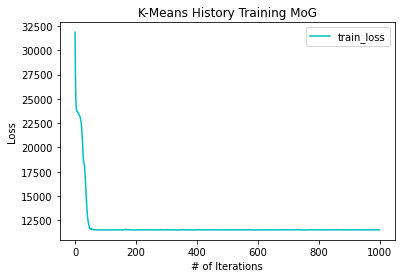

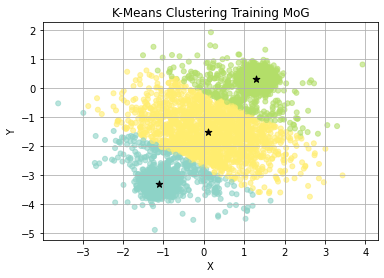

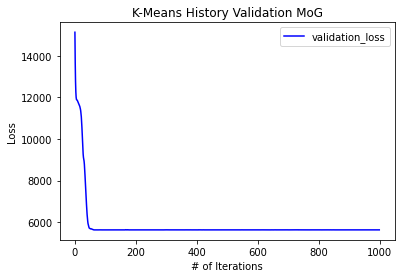

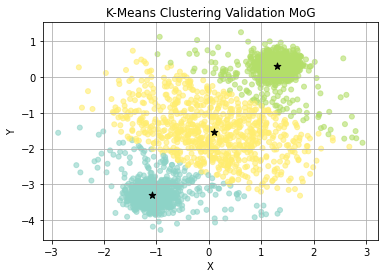

In [41]:
val_loss_3k_MoG = k_means_MoG(3)

I found the best model parameters to be learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5 and interations = 300 for this case (in the above graphs you can see up to 1000 iterations, which tends to oscillate the outputs)

###2.2.2.-

Final Training Loss MoG 23267.172
Final Validation Loss MoG 11649.419
Training Class MoG: 0 Percentage: 100.0 %
Validation Class MoG: 0 Percentage: 100.0 %


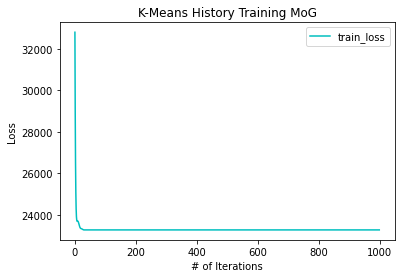

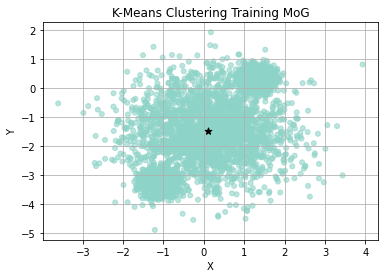

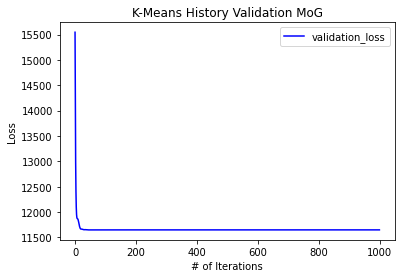

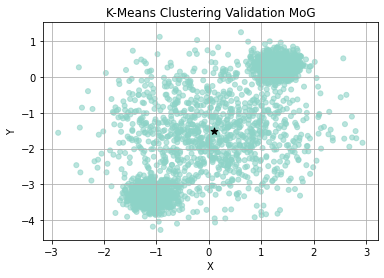

Final Training Loss MoG 16159.687
Final Validation Loss MoG 7981.5034
Training Class MoG: 0 Percentage: 43.84280785960702 %
Training Class MoG: 1 Percentage: 56.15719214039298 %
Validation Class MoG: 0 Percentage: 42.304230423042306 %
Validation Class MoG: 1 Percentage: 57.695769576957694 %


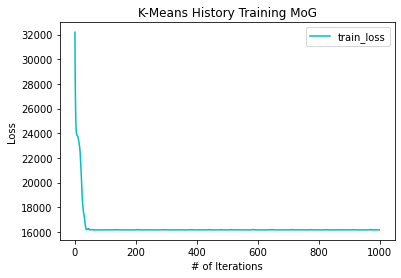

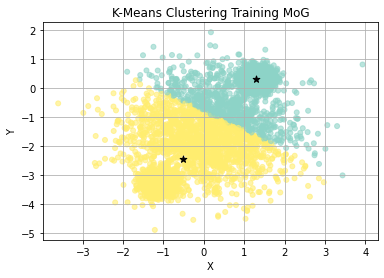

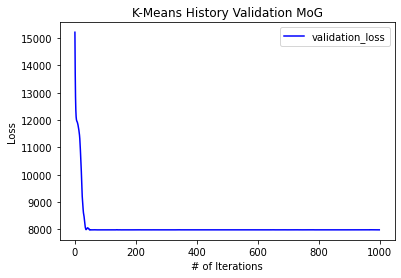

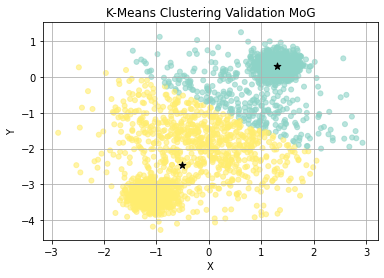

Final Training Loss MoG 11510.136
Final Validation Loss MoG 5625.765
Training Class MoG: 0 Percentage: 37.04814759262037 %
Training Class MoG: 1 Percentage: 24.838758062096897 %
Training Class MoG: 2 Percentage: 38.11309434528273 %
Validation Class MoG: 0 Percentage: 39.333933393339336 %
Validation Class MoG: 1 Percentage: 23.61236123612361 %
Validation Class MoG: 2 Percentage: 37.05370537053705 %


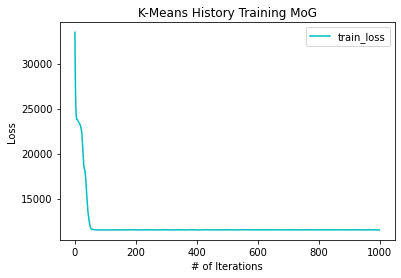

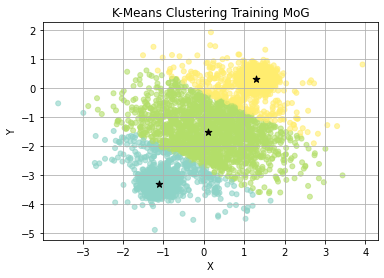

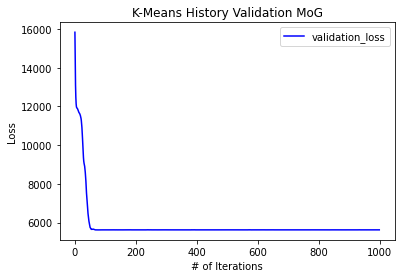

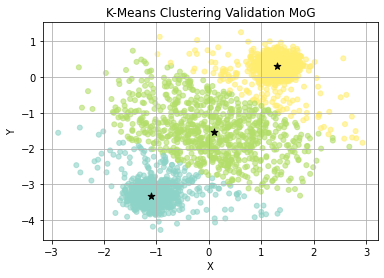

Final Training Loss MoG 11517.4
Final Validation Loss MoG 5625.108
Training Class MoG: 0 Percentage: 13.43932803359832 %
Training Class MoG: 1 Percentage: 36.748162591870404 %
Training Class MoG: 2 Percentage: 37.768111594420276 %
Training Class MoG: 3 Percentage: 12.044397780110994 %
Validation Class MoG: 0 Percentage: 12.001200120012001 %
Validation Class MoG: 1 Percentage: 39.15391539153915 %
Validation Class MoG: 2 Percentage: 36.933693369336936 %
Validation Class MoG: 3 Percentage: 11.911191119111912 %


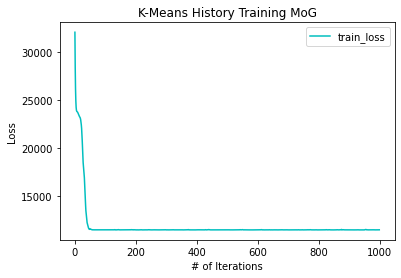

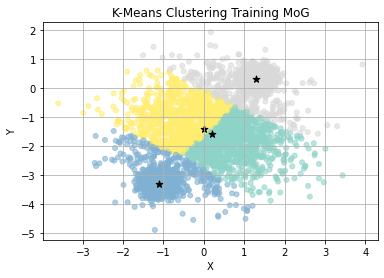

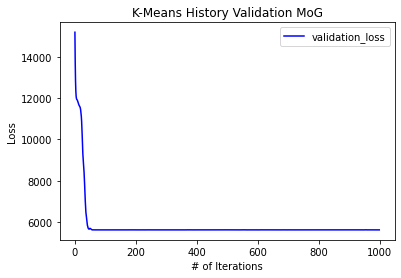

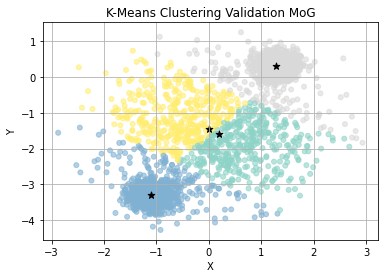

Final Training Loss MoG 11510.525
Final Validation Loss MoG 5625.22
Training Class MoG: 0 Percentage: 36.748162591870404 %
Training Class MoG: 1 Percentage: 12.14939253037348 %
Training Class MoG: 2 Percentage: 13.334333283335834 %
Training Class MoG: 3 Percentage: 0.02999850007499625 %
Training Class MoG: 4 Percentage: 37.73811309434528 %
Validation Class MoG: 0 Percentage: 39.093909390939096 %
Validation Class MoG: 1 Percentage: 12.121212121212121 %
Validation Class MoG: 2 Percentage: 11.911191119111912 %
Validation Class MoG: 3 Percentage: 0.0 %
Validation Class MoG: 4 Percentage: 36.873687368736874 %


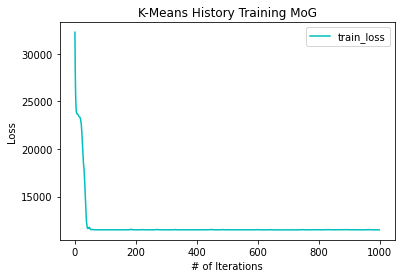

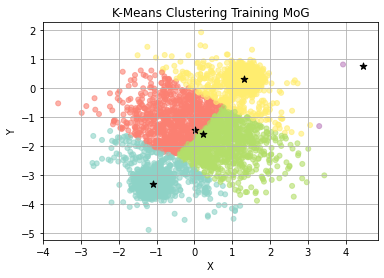

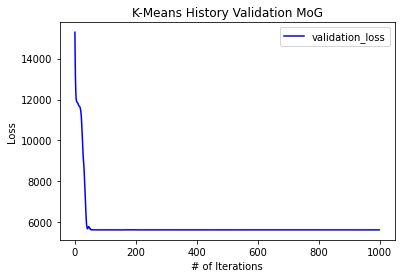

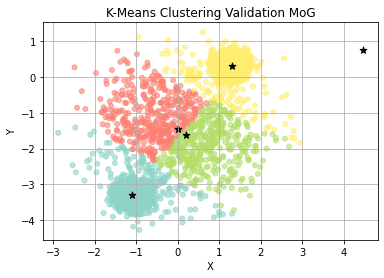

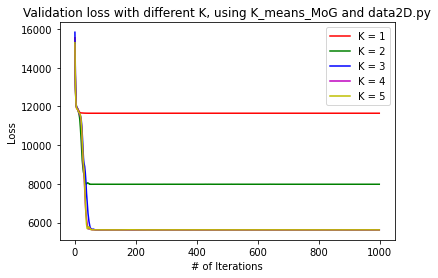

In [42]:
valid_MoG = []
valid_MoG.append(k_means_MoG(1, need_update=False))
valid_MoG.append(k_means_MoG(2, need_update=False))
valid_MoG.append(k_means_MoG(3, need_update=False))
valid_MoG.append(k_means_MoG(4, need_update=False))
valid_MoG.append(k_means_MoG(5, need_update=False))

plt.figure(1)
plt.plot(range(len(valid_MoG[0])),valid_MoG[0],c="r", label="K = 1")
# plt.plot(range(len(valid_losses)),valid_losses,c="r", label="valid_loss")
plt.plot(range(len(valid_MoG[1])),valid_MoG[1],c="g", label="K = 2")
plt.plot(range(len(valid_MoG[2])),valid_MoG[2],c="b", label="K = 3")
plt.plot(range(len(valid_MoG[3])),valid_MoG[3],c="m", label="K = 4")
plt.plot(range(len(valid_MoG[4])),valid_MoG[4],c="y", label="K = 5")
plt.legend(loc = "best")
plt.title('Validation loss with different K, using K_means_MoG and data2D.py')
plt.xlabel('# of Iterations')
plt.ylabel('Loss')
plt.show()

The best value of K for this case is K=4 beacase it has one of the lowest final losses while still keeping the sets coherent, ergo it does not waste a cluster in the upper right hand corner as in the K=5 case.

###2.2.3.-

In [27]:
data_int = 100

In [28]:
if data_int == 2:
  data = np.load(data_path_2)
  
elif data_int == 100:
  data = np.load(data_path_100)

[num_pts, dim] = np.shape(data)
# For Validation set
#if is_valid:
valid_batch = int(num_pts / 3.0)
np.random.seed(45689)
rnd_idx = np.arange(num_pts)
np.random.shuffle(rnd_idx)
val_data = data[rnd_idx[:valid_batch]]
data = data[rnd_idx[valid_batch:]]

####GMM

Final Training Loss MoG 43380.84
Final Validation Loss MoG 21691.07
Training Class MoG: 0 Percentage: 40.31798410079496 %
Training Class MoG: 1 Percentage: 29.308534573271338 %
Training Class MoG: 2 Percentage: 10.094495275236238 %
Training Class MoG: 3 Percentage: 10.019499025048747 %
Training Class MoG: 4 Percentage: 10.259487025648717 %
Validation Class MoG: 0 Percentage: 39.363936393639364 %
Validation Class MoG: 1 Percentage: 31.383138313831385 %
Validation Class MoG: 2 Percentage: 9.900990099009901 %
Validation Class MoG: 3 Percentage: 9.960996099609961 %
Validation Class MoG: 4 Percentage: 9.390939093909392 %


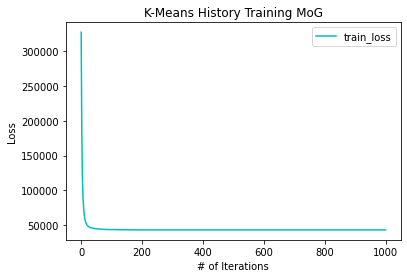

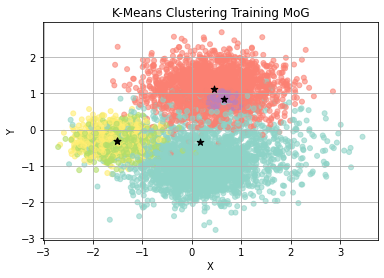

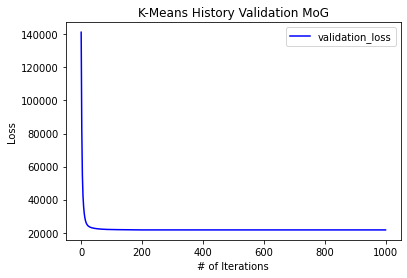

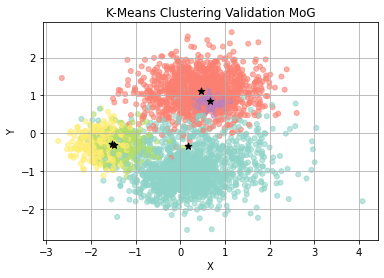

Final Training Loss MoG 44156.812
Final Validation Loss MoG 22069.13
Training Class MoG: 0 Percentage: 4.829758512074396 %
Training Class MoG: 1 Percentage: 20.353982300884955 %
Training Class MoG: 2 Percentage: 4.8747562621868905 %
Training Class MoG: 3 Percentage: 5.429728513574322 %
Training Class MoG: 4 Percentage: 5.354732263386831 %
Training Class MoG: 5 Percentage: 24.94375281235938 %
Training Class MoG: 6 Percentage: 7.259637018149093 %
Training Class MoG: 7 Percentage: 20.038998050097494 %
Training Class MoG: 8 Percentage: 3.494825258737063 %
Training Class MoG: 9 Percentage: 3.4198290085495726 %
Validation Class MoG: 0 Percentage: 5.7905790579057905 %
Validation Class MoG: 1 Percentage: 19.29192919291929 %
Validation Class MoG: 2 Percentage: 4.8004800480048 %
Validation Class MoG: 3 Percentage: 6.390639063906391 %
Validation Class MoG: 4 Percentage: 17.4017401740174 %
Validation Class MoG: 5 Percentage: 12.001200120012001 %
Validation Class MoG: 6 Percentage: 1.89018901890189

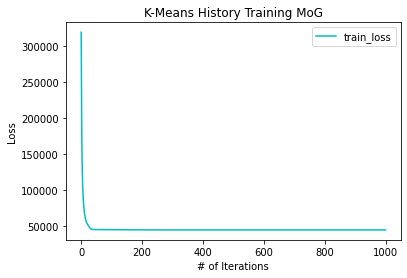

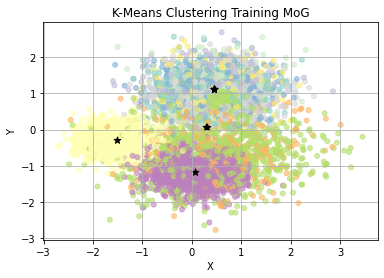

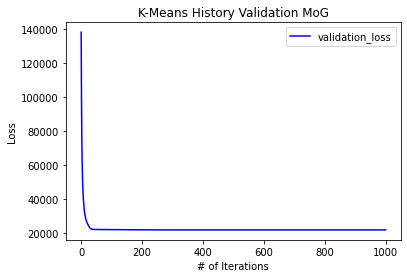

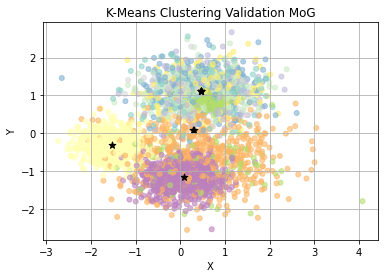

Final Training Loss MoG 44155.97
Final Validation Loss MoG 22069.154
Training Class MoG: 0 Percentage: 4.214789260536973 %
Training Class MoG: 1 Percentage: 10.304484775761212 %
Training Class MoG: 2 Percentage: 5.489725513724314 %
Training Class MoG: 3 Percentage: 3.4198290085495726 %
Training Class MoG: 4 Percentage: 1.6499175041247938 %
Training Class MoG: 5 Percentage: 2.5798710064496775 %
Training Class MoG: 6 Percentage: 13.244337783110845 %
Training Class MoG: 7 Percentage: 10.574471276436178 %
Training Class MoG: 8 Percentage: 2.369881505924704 %
Training Class MoG: 9 Percentage: 9.734513274336283 %
Training Class MoG: 10 Percentage: 2.6548672566371683 %
Training Class MoG: 11 Percentage: 7.559622018899055 %
Training Class MoG: 12 Percentage: 3.464826758662067 %
Training Class MoG: 13 Percentage: 2.4598770061496924 %
Training Class MoG: 14 Percentage: 20.278986050697466 %
Validation Class MoG: 0 Percentage: 2.6402640264026402 %
Validation Class MoG: 1 Percentage: 10.23102310231

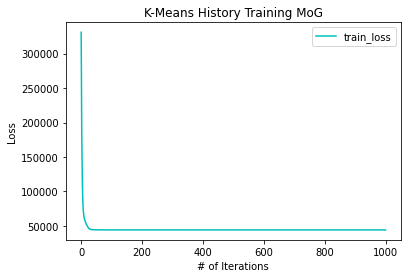

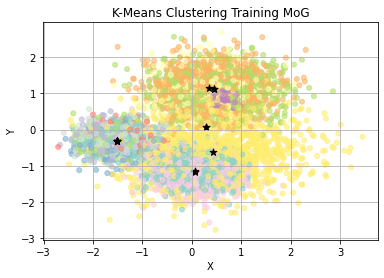

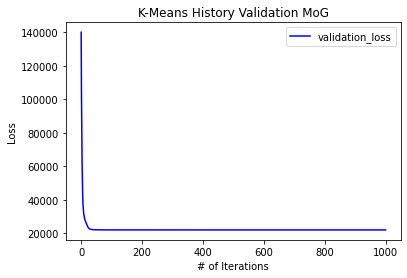

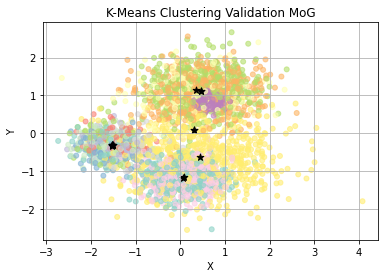

Final Training Loss MoG 44155.89
Final Validation Loss MoG 22069.146
Training Class MoG: 0 Percentage: 20.038998050097494 %
Training Class MoG: 1 Percentage: 2.5948702564871757 %
Training Class MoG: 2 Percentage: 2.8198590070496476 %
Training Class MoG: 3 Percentage: 2.4298785060746964 %
Training Class MoG: 4 Percentage: 1.0349482525873706 %
Training Class MoG: 5 Percentage: 0.95995200239988 %
Training Class MoG: 6 Percentage: 1.7099145042747863 %
Training Class MoG: 7 Percentage: 2.8048597570121494 %
Training Class MoG: 8 Percentage: 3.6598170091495423 %
Training Class MoG: 9 Percentage: 4.454777261136943 %
Training Class MoG: 10 Percentage: 2.519874006299685 %
Training Class MoG: 11 Percentage: 0.8249587520623969 %
Training Class MoG: 12 Percentage: 3.704814759262037 %
Training Class MoG: 13 Percentage: 3.83980800959952 %
Training Class MoG: 14 Percentage: 4.049797510124494 %
Training Class MoG: 15 Percentage: 9.059547022648868 %
Training Class MoG: 16 Percentage: 2.5648717564121792 

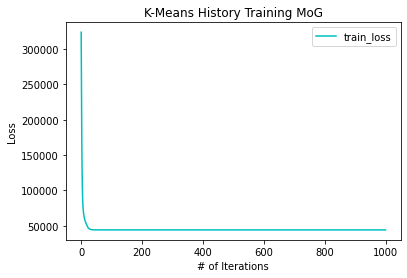

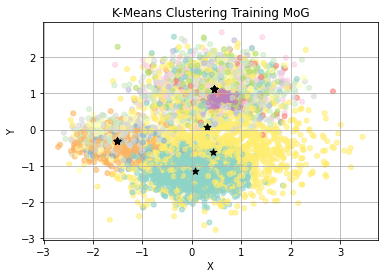

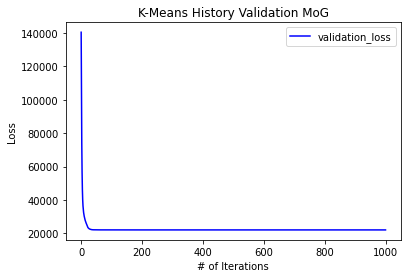

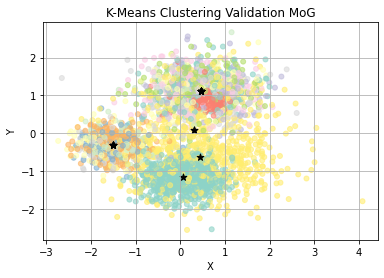

Final Training Loss MoG 42653.367
Final Validation Loss MoG 21321.16
Training Class MoG: 0 Percentage: 8.939553022348882 %
Training Class MoG: 1 Percentage: 3.8698065096745164 %
Training Class MoG: 2 Percentage: 0.32998350082495875 %
Training Class MoG: 3 Percentage: 1.4549272536373181 %
Training Class MoG: 4 Percentage: 4.739763011849408 %
Training Class MoG: 5 Percentage: 0.71996400179991 %
Training Class MoG: 6 Percentage: 11.489425528723563 %
Training Class MoG: 7 Percentage: 1.9949002549872505 %
Training Class MoG: 8 Percentage: 10.094495275236238 %
Training Class MoG: 9 Percentage: 8.789560521973902 %
Training Class MoG: 10 Percentage: 1.7099145042747863 %
Training Class MoG: 11 Percentage: 10.019499025048747 %
Training Class MoG: 12 Percentage: 1.1399430028498576 %
Training Class MoG: 13 Percentage: 1.9649017549122545 %
Training Class MoG: 14 Percentage: 0.3449827508624569 %
Training Class MoG: 15 Percentage: 3.5698215089245537 %
Training Class MoG: 16 Percentage: 3.659817009149

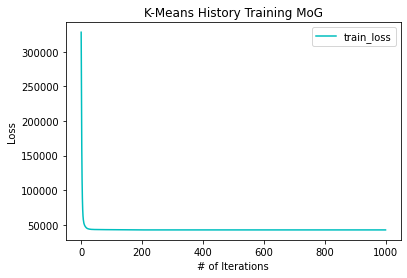

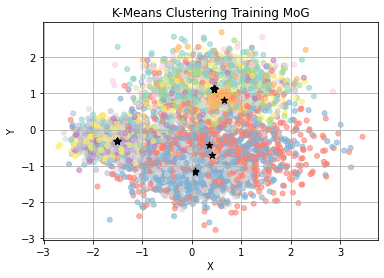

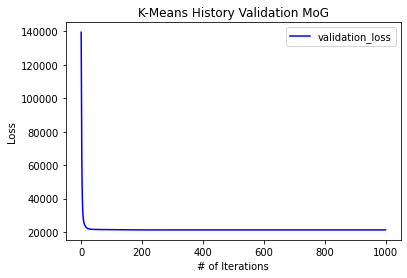

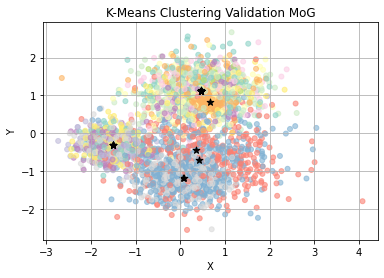

Final Training Loss MoG 42653.21
Final Validation Loss MoG 21321.225
Training Class MoG: 0 Percentage: 3.584820758962052 %
Training Class MoG: 1 Percentage: 3.2848357582120893 %
Training Class MoG: 2 Percentage: 2.144892755362232 %
Training Class MoG: 3 Percentage: 4.199790010499475 %
Training Class MoG: 4 Percentage: 10.019499025048747 %
Training Class MoG: 5 Percentage: 0.7649617519124043 %
Training Class MoG: 6 Percentage: 0.9749512524373781 %
Training Class MoG: 7 Percentage: 5.084745762711864 %
Training Class MoG: 8 Percentage: 0.0 %
Training Class MoG: 9 Percentage: 0.014999250037498125 %
Training Class MoG: 10 Percentage: 3.7498125093745314 %
Training Class MoG: 11 Percentage: 2.2048897555122244 %
Training Class MoG: 12 Percentage: 0.2249887505624719 %
Training Class MoG: 13 Percentage: 2.5648717564121792 %
Training Class MoG: 14 Percentage: 4.709764511774411 %
Training Class MoG: 15 Percentage: 3.8698065096745164 %
Training Class MoG: 16 Percentage: 0.04499775011249438 %
Traini

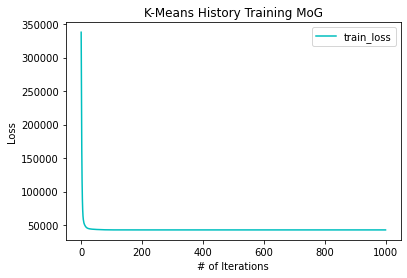

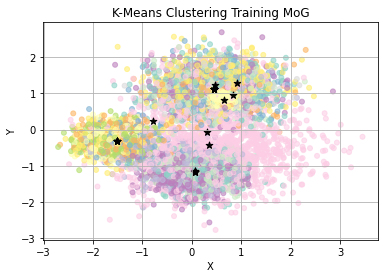

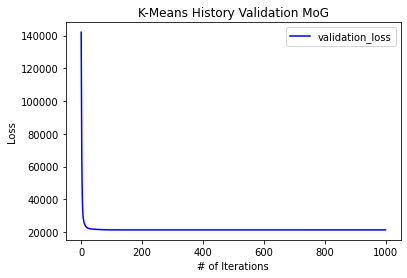

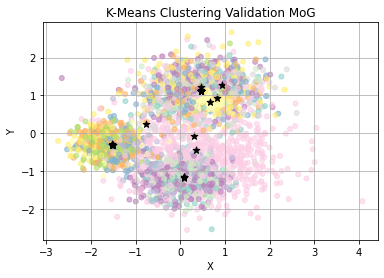

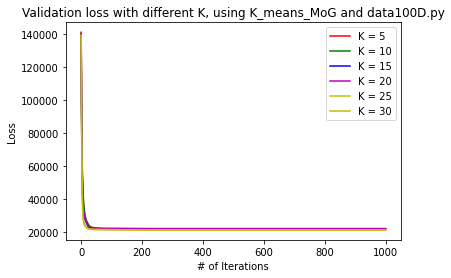

In [29]:
valid_MoG = []
valid_MoG.append(k_means_MoG(5, need_update=False))
valid_MoG.append(k_means_MoG(10, need_update=False))
valid_MoG.append(k_means_MoG(15, need_update=False))
valid_MoG.append(k_means_MoG(20, need_update=False))
valid_MoG.append(k_means_MoG(25, need_update=False))
valid_MoG.append(k_means_MoG(30, need_update=False))

plt.figure(1)
plt.plot(range(len(valid_MoG[0])),valid_MoG[0],c="r", label="K = 5")
# plt.plot(range(len(valid_losses)),valid_losses,c="r", label="valid_loss")
plt.plot(range(len(valid_MoG[1])),valid_MoG[1],c="g", label="K = 10")
plt.plot(range(len(valid_MoG[2])),valid_MoG[2],c="b", label="K = 15")
plt.plot(range(len(valid_MoG[3])),valid_MoG[3],c="m", label="K = 20")
plt.plot(range(len(valid_MoG[4])),valid_MoG[4],c="y", label="K = 25")
plt.plot(range(len(valid_MoG[5])),valid_MoG[4],c="y", label="K = 30")
plt.legend(loc = "best")
plt.title('Validation loss with different K, using K_means_MoG and data100D.py')
plt.xlabel('# of Iterations')
plt.ylabel('Loss')
plt.show()

####K-means

Final Training Loss 247166.52
Final Validation Loss 122378.984
Training Class: 0 Percentage: 20.278986050697466 %
Training Class: 1 Percentage: 30.373481325933703 %
Training Class: 2 Percentage: 20.038998050097494 %
Training Class: 3 Percentage: 0.0 %
Training Class: 4 Percentage: 29.308534573271338 %
Validation Class: 0 Percentage: 19.44194419441944 %
Validation Class: 1 Percentage: 29.252925292529252 %
Validation Class: 2 Percentage: 19.921992199219922 %
Validation Class: 3 Percentage: 0.0 %
Validation Class: 4 Percentage: 31.383138313831385 %


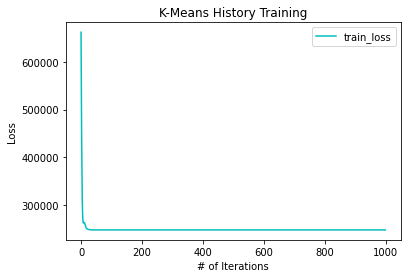

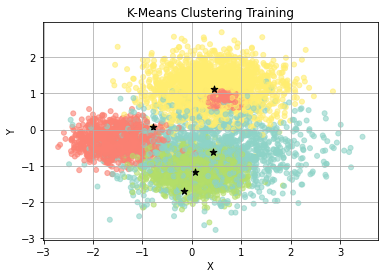

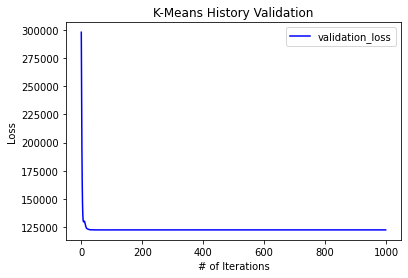

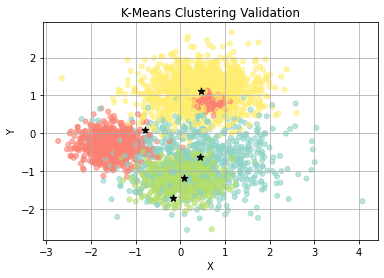

Final Training Loss 141078.66
Final Validation Loss 70495.58
Training Class: 0 Percentage: 10.019499025048747 %
Training Class: 1 Percentage: 7.619619019049048 %
Training Class: 2 Percentage: 20.038998050097494 %
Training Class: 3 Percentage: 7.964601769911504 %
Training Class: 4 Percentage: 0.0 %
Training Class: 5 Percentage: 20.353982300884955 %
Training Class: 6 Percentage: 0.0 %
Training Class: 7 Percentage: 20.278986050697466 %
Training Class: 8 Percentage: 6.374681265936704 %
Training Class: 9 Percentage: 7.349632518374081 %
Validation Class: 0 Percentage: 9.960996099609961 %
Validation Class: 1 Percentage: 7.110711071107111 %
Validation Class: 2 Percentage: 19.921992199219922 %
Validation Class: 3 Percentage: 8.7008700870087 %
Validation Class: 4 Percentage: 0.0 %
Validation Class: 5 Percentage: 19.29192919291929 %
Validation Class: 6 Percentage: 0.0 %
Validation Class: 7 Percentage: 19.44194419441944 %
Validation Class: 8 Percentage: 7.080708070807081 %
Validation Class: 9 Perc

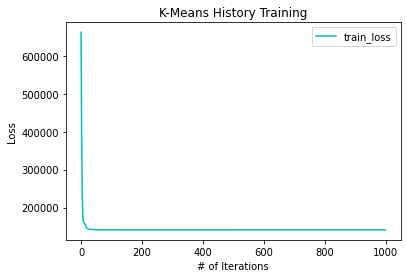

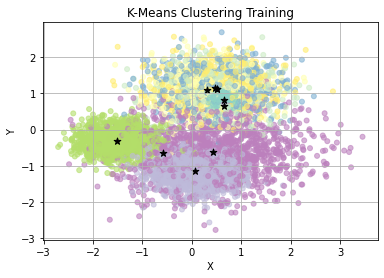

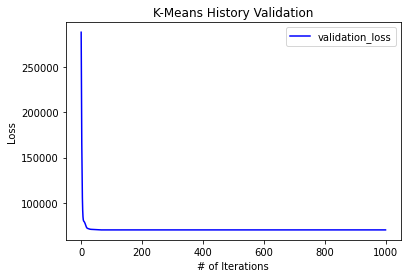

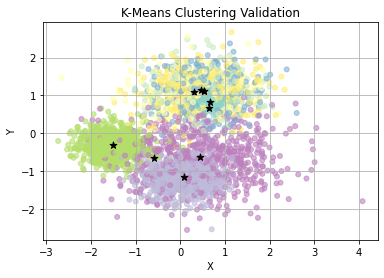

Final Training Loss 138414.11
Final Validation Loss 69185.29
Training Class: 0 Percentage: 6.869656517174142 %
Training Class: 1 Percentage: 20.353982300884955 %
Training Class: 2 Percentage: 7.5746212689365535 %
Training Class: 3 Percentage: 0.0 %
Training Class: 4 Percentage: 10.019499025048747 %
Training Class: 5 Percentage: 0.0 %
Training Class: 6 Percentage: 0.014999250037498125 %
Training Class: 7 Percentage: 6.839658017099145 %
Training Class: 8 Percentage: 20.038998050097494 %
Training Class: 9 Percentage: 0.0 %
Training Class: 10 Percentage: 0.0 %
Training Class: 11 Percentage: 6.839658017099145 %
Training Class: 12 Percentage: 6.569671516424179 %
Training Class: 13 Percentage: 7.709614519274036 %
Training Class: 14 Percentage: 7.169641517924104 %
Validation Class: 0 Percentage: 6.690669066906691 %
Validation Class: 1 Percentage: 19.29192919291929 %
Validation Class: 2 Percentage: 8.7008700870087 %
Validation Class: 3 Percentage: 0.0 %
Validation Class: 4 Percentage: 9.9609960

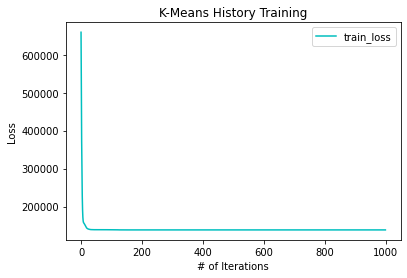

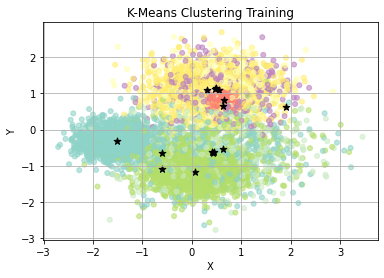

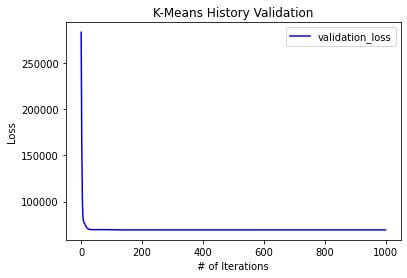

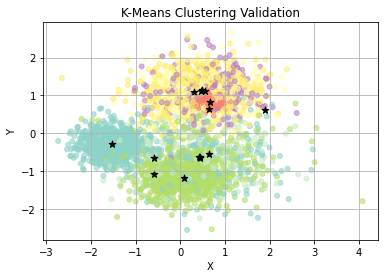

Final Training Loss 137746.38
Final Validation Loss 68844.15
Training Class: 0 Percentage: 10.019499025048747 %
Training Class: 1 Percentage: 0.0 %
Training Class: 2 Percentage: 0.0 %
Training Class: 3 Percentage: 5.144742762861857 %
Training Class: 4 Percentage: 5.354732263386831 %
Training Class: 5 Percentage: 7.949602519874007 %
Training Class: 6 Percentage: 20.353982300884955 %
Training Class: 7 Percentage: 0.0 %
Training Class: 8 Percentage: 7.544622768861557 %
Training Class: 9 Percentage: 0.0 %
Training Class: 10 Percentage: 4.904754762261887 %
Training Class: 11 Percentage: 0.0 %
Training Class: 12 Percentage: 0.0 %
Training Class: 13 Percentage: 7.334633268336583 %
Training Class: 14 Percentage: 0.0 %
Training Class: 15 Percentage: 20.038998050097494 %
Training Class: 16 Percentage: 0.0 %
Training Class: 17 Percentage: 6.47967601619919 %
Training Class: 18 Percentage: 0.0 %
Training Class: 19 Percentage: 4.8747562621868905 %
Validation Class: 0 Percentage: 9.960996099609961 %


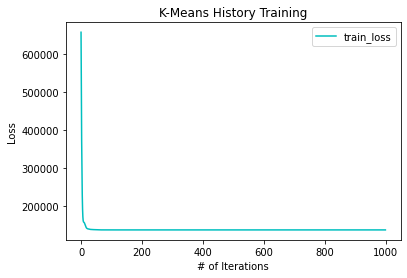

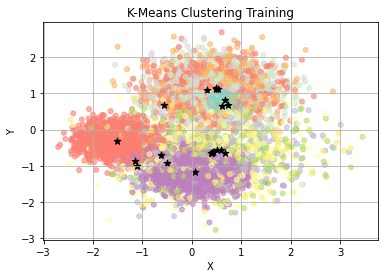

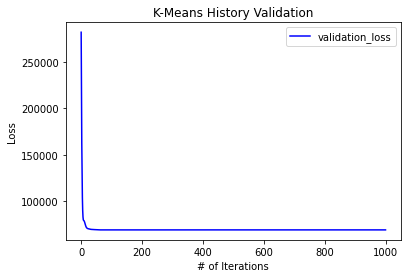

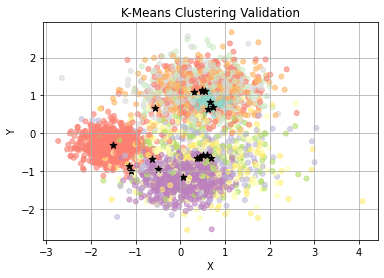

Final Training Loss 137832.08
Final Validation Loss 68852.79
Training Class: 0 Percentage: 0.0 %
Training Class: 1 Percentage: 0.0 %
Training Class: 2 Percentage: 0.0 %
Training Class: 3 Percentage: 5.1897405129743515 %
Training Class: 4 Percentage: 0.0 %
Training Class: 5 Percentage: 0.0 %
Training Class: 6 Percentage: 4.199790010499475 %
Training Class: 7 Percentage: 0.0 %
Training Class: 8 Percentage: 0.0 %
Training Class: 9 Percentage: 7.154642267886605 %
Training Class: 10 Percentage: 0.0 %
Training Class: 11 Percentage: 0.0 %
Training Class: 12 Percentage: 0.0 %
Training Class: 13 Percentage: 20.353982300884955 %
Training Class: 14 Percentage: 8.009599520023999 %
Training Class: 15 Percentage: 6.569671516424179 %
Training Class: 16 Percentage: 0.0 %
Training Class: 17 Percentage: 0.0 %
Training Class: 18 Percentage: 10.019499025048747 %
Training Class: 19 Percentage: 5.639718014099295 %
Training Class: 20 Percentage: 7.5746212689365535 %
Training Class: 21 Percentage: 20.03899805

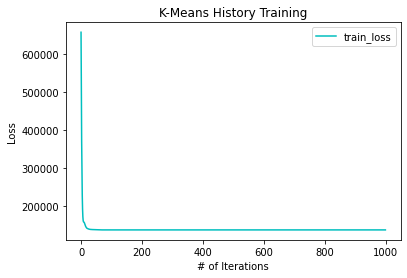

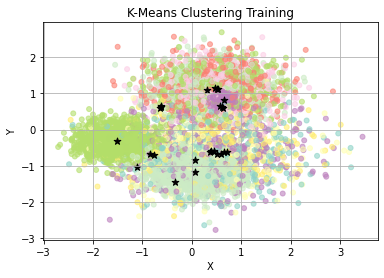

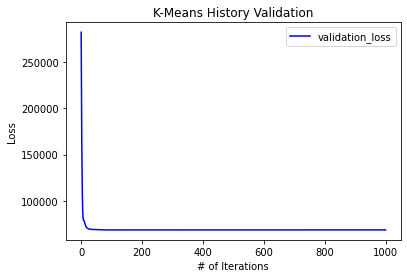

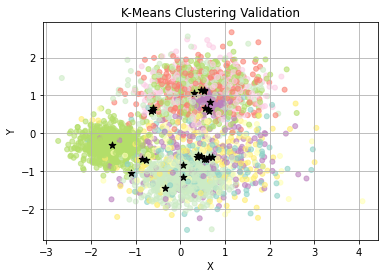

Final Training Loss 135380.58
Final Validation Loss 67738.05
Training Class: 0 Percentage: 2.3248837558122095 %
Training Class: 1 Percentage: 0.0 %
Training Class: 2 Percentage: 0.0 %
Training Class: 3 Percentage: 0.0 %
Training Class: 4 Percentage: 2.1298935053247336 %
Training Class: 5 Percentage: 0.0 %
Training Class: 6 Percentage: 1.7249137543122843 %
Training Class: 7 Percentage: 1.9349032548372582 %
Training Class: 8 Percentage: 5.1297435128243585 %
Training Class: 9 Percentage: 0.0 %
Training Class: 10 Percentage: 6.059697015149243 %
Training Class: 11 Percentage: 2.6848657567121643 %
Training Class: 12 Percentage: 0.014999250037498125 %
Training Class: 13 Percentage: 0.0 %
Training Class: 14 Percentage: 10.019499025048747 %
Training Class: 15 Percentage: 0.0 %
Training Class: 16 Percentage: 0.0 %
Training Class: 17 Percentage: 6.1946902654867255 %
Training Class: 18 Percentage: 2.369881505924704 %
Training Class: 19 Percentage: 2.189890505474726 %
Training Class: 20 Percentage:

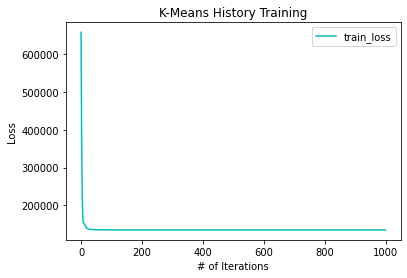

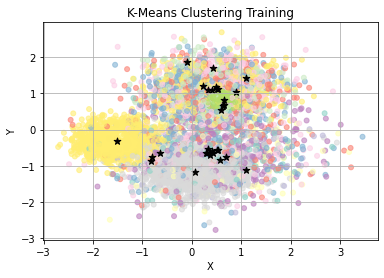

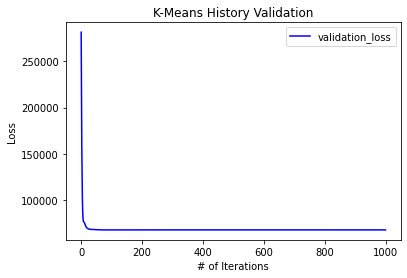

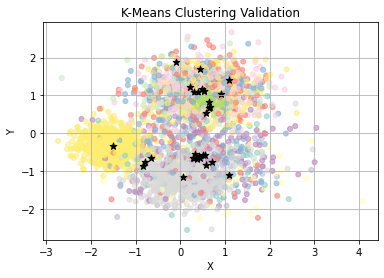

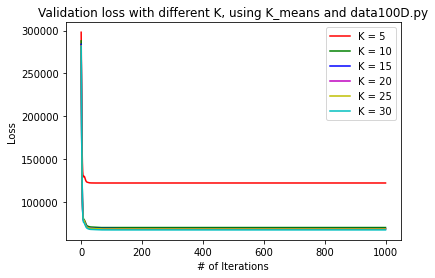

In [30]:
valid = []
valid.append(k_means(5, need_update=False))
valid.append(k_means(10, need_update=False))
valid.append(k_means(15, need_update=False))
valid.append(k_means(20, need_update=False))
valid.append(k_means(25, need_update=False))
valid.append(k_means(30, need_update=False))
    

plt.figure(1)
plt.plot(range(len(valid[0])),valid[0],c="r", label="K = 5")
# plt.plot(range(len(valid_losses)),valid_losses,c="r", label="valid_loss")
plt.plot(range(len(valid[1])),valid[1],c="g", label="K = 10")
plt.plot(range(len(valid[2])),valid[2],c="b", label="K = 15")
plt.plot(range(len(valid[3])),valid[3],c="m", label="K = 20")
plt.plot(range(len(valid[4])),valid[4],c="y", label="K = 25")
plt.plot(range(len(valid[5])),valid[5],c="c", label="K = 30")
plt.legend(loc = "best")
plt.title('Validation loss with different K, using K_means and data100D.py')
plt.xlabel('# of Iterations')
plt.ylabel('Loss')
plt.show()

Looking at the Validation loss of both K-means and MoG I believe there's actually around 10 clusters in the set. I draw this conclusion after observing the huge gap in the validation losses of K = 5 and K = 10, as well as the close loss that K>5 has overall.

Learnt results: K-means VS MoG

The first three noticeable differences on the results and performance of both models come from their execution time, their final losses and the percentage of data in their clusters:
 

*   K-means was faster at convergence due to its simplicity.
*   MoG had lower losses across all K pretty much; it is also worth noting that K-means showed a huge jump in validation loss starting at K=10 (from K=5), whereas MoG had no such jump.
*   MoG had better distribution across its clusters, as show by the (less than with K-means) number of clusters with 0 elements.